## Часть 2
1. Обучить сеть DeepFM на бинарную задачу классифкации на датасете "adult".
2. Обучающая и валидационная выборки лежат в папке data в week08 и сам проект в папке DeepFM.
3. Перед обучением сети првоести анализ и предобработку данных.
4. Выложить код и показать точность и графики обучения.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pickle
from tqdm.notebook import tqdm
import random

from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score

import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
from lesson_materials.deepFM.network import DeepFMNet


import mlflow
from mlflow.exceptions import MlflowException
from mlflow.tracking import MlflowClient

In [2]:
path_to_data = 'data/encoded_dataset.csv'
path_to_dicts = 'data/auxiliary_dicts.pkl'

SEED = 42
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True

In [3]:
with open(path_to_dicts, 'rb') as file:
    category_number_dict, numerical_columns, categorical_colums = pickle.load(file)

In [4]:
df = pd.read_csv(path_to_data)
df.head()

,Unnamed: 0,workclass,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,salary,age_log,fnlwgt_log,capital_loss_log,hours_per_week_bins,native_country
0,0,3,0,12.0,1,0,5,1,0,0,1,3.891820,11.526039,7.551187,2,1
1,1,3,4,14.0,0,3,1,1,1,10520,1,3.784190,12.374743,0.000000,3,1
2,2,3,3,10.0,0,0,4,0,0,0,0,3.637586,11.474029,0.000000,2,1
3,3,4,6,15.0,1,8,0,2,1,0,1,3.637586,11.633788,0.000000,2,1
4,4,5,7,10.0,1,7,5,0,0,0,0,3.737670,11.318090,0.000000,3,1


In [5]:
train_data, valid_data = train_test_split(df, test_size=0.2, stratify=df.salary)

In [6]:
class CustomDataset(Dataset):
    def __init__(self, df, numerical_columns, categorical_colums):
        self.df = df
        self.numerical_columns = numerical_columns
        self.categorical_colums = categorical_colums
        
        self.columns = self.categorical_colums + self.numerical_columns
        
        self.X = self.df[self.columns].reset_index(drop=True)
        self.y = df.salary.to_numpy()
        
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, indx):
        row = self.X.take([indx], axis=0)

        row = {col: torch.tensor(row[col].values, dtype=torch.float32) for i, col in enumerate(self.columns)}

        return row, np.float32(self.y[indx])

In [7]:
train_dataset = CustomDataset(train_data, numerical_columns, categorical_colums)
valid_dataset = CustomDataset(valid_data, numerical_columns, categorical_colums)

In [9]:
def experiment_mlflow(model, train_loader, valid_loader, epoches, criterion, optimizer):
    for epoch in tqdm(range(epoches)):
        train_loss = 0
        valid_loss = 0
        correct_train = 0
        correct_valid = 0
        model.train()
        for X, y in tqdm(train_loader):
            optimizer.zero_grad()
            output = model(X)
            loss = criterion(output, y)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            predict = (torch.sigmoid(output.cpu())>0.5).long()
            correct_train += (y.cpu()==predict).sum()

        model.eval()
        for X, y in tqdm(valid_loader):
            with torch.no_grad():
                output = model(X)
                loss = criterion(output, y)
                valid_loss += loss.item()
                predict = (torch.sigmoid(output.cpu())>0.5).long()
                correct_valid += (y.cpu()==predict).sum()

        train_loss = train_loss/len(train_dataset)
        valid_loss = valid_loss/len(valid_dataset)
        train_accuracy = correct_train/len(train_dataset)
        valid_accuracy = correct_valid/len(valid_dataset)
            
        mlflow.log_metric("train/loss", float(train_loss), step=epoch)
        mlflow.log_metric("valid/loss", float(valid_loss), step=epoch)
        mlflow.log_metric("train/accuracy", float(train_accuracy), step=epoch)
        mlflow.log_metric("valid/accuracy", float(valid_accuracy), step=epoch)

        print(f'Epoch: {epoch}, Train loss: {round(train_loss, 4)},  Valid loss: {round(valid_loss, 4)}')
        print(f'Epoch: {epoch}, Train Accuracy: {train_accuracy},  Valid Accuracy: {valid_accuracy}')

In [19]:
EPOCHES = 30
EMBEDDING_SIZE = 5
BATCH_SIZE = 512
NROF_LAYERS = 2
NROF_NEURONS = 16
DEEP_OUTPUT_SIZE = 16
NROF_OUT_CLASSES = 1
LEARNING_RATE = 3e-4

In [20]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)

model = DeepFMNet(nrof_cat=category_number_dict,
                  emb_dim=EMBEDDING_SIZE,
                  emb_columns=categorical_colums,
                  numeric_columns=numerical_columns,
                  nrof_layers=NROF_LAYERS,
                  nrof_neurons=NROF_NEURONS,
                  output_size=DEEP_OUTPUT_SIZE,
                  nrof_out_classes=NROF_OUT_CLASSES).to(DEVICE)

criterion = torch.nn.BCEWithLogitsLoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [21]:
client = MlflowClient()
try:
    experiment_id = client.create_experiment("Experiment_DeepFM")
except MlflowException:  # If such experiment already exist
    experiment_id = client.get_experiment_by_name("Experiment_DeepFM").experiment_id
        
with mlflow.start_run(run_name='MLFlow_run', experiment_id=experiment_id):
    mlflow.log_param("epoches", EPOCHES)
    mlflow.log_param("batch_size", BATCH_SIZE)
    mlflow.log_param("optimizer", 'Adam')
    mlflow.log_param("learning_rate", LEARNING_RATE)
    mlflow.log_param("embedding_dim", EMBEDDING_SIZE)
    mlflow.log_param("NROF_LAYERS", NROF_LAYERS)
    mlflow.log_param("NROF_NEURONS", NROF_NEURONS)
    mlflow.log_param("DEEP_OUTPUT_SIZE", DEEP_OUTPUT_SIZE)
    mlflow.log_param("SEED", SEED)
    

    experiment_mlflow(model, train_loader, valid_loader, EPOCHES, criterion, optimizer)

  0%|          | 0/30 [00:00<?, ?it/s]

  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0017821145603961802 0.0016857226580472915
Epoch: 0, Train loss: 0.0018,  Valid loss: 0.0017
Epoch: 0, Train Accuracy: 0.4325547516345978,  Valid Accuracy: 0.48585745692253113


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0013787032912756952 0.0013193905074164423
Epoch: 1, Train loss: 0.0014,  Valid loss: 0.0013
Epoch: 1, Train Accuracy: 0.5877313613891602,  Valid Accuracy: 0.668336808681488


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.001111466319252889 0.0010699904974624068
Epoch: 2, Train loss: 0.0011,  Valid loss: 0.0011
Epoch: 2, Train Accuracy: 0.7180554270744324,  Valid Accuracy: 0.7580410242080688


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0009366453060055187 0.0009075952824780181
Epoch: 3, Train loss: 0.0009,  Valid loss: 0.0009
Epoch: 3, Train Accuracy: 0.7835205793380737,  Valid Accuracy: 0.8071763515472412


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.000824121698878051 0.0008210355570382981
Epoch: 4, Train loss: 0.0008,  Valid loss: 0.0008
Epoch: 4, Train Accuracy: 0.817101776599884,  Valid Accuracy: 0.8268951177597046


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0007569863735921341 0.0007605640437735173
Epoch: 5, Train loss: 0.0008,  Valid loss: 0.0008
Epoch: 5, Train Accuracy: 0.828093409538269,  Valid Accuracy: 0.8385323882102966


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0007131087958721185 0.0007297504799844221
Epoch: 6, Train loss: 0.0007,  Valid loss: 0.0007
Epoch: 6, Train Accuracy: 0.8375495076179504,  Valid Accuracy: 0.8445127010345459


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006919649092331957 0.0007073767922778921
Epoch: 7, Train loss: 0.0007,  Valid loss: 0.0007
Epoch: 7, Train Accuracy: 0.8408227562904358,  Valid Accuracy: 0.8480685353279114


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006694763653166397 0.000695191052805073
Epoch: 8, Train loss: 0.0007,  Valid loss: 0.0007
Epoch: 8, Train Accuracy: 0.844540536403656,  Valid Accuracy: 0.8496848344802856


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006593602990156078 0.000683916044751604
Epoch: 9, Train loss: 0.0007,  Valid loss: 0.0007
Epoch: 9, Train Accuracy: 0.8470863699913025,  Valid Accuracy: 0.8522709012031555


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006548849406493257 0.0006811263460286006
Epoch: 10, Train loss: 0.0007,  Valid loss: 0.0007
Epoch: 10, Train Accuracy: 0.8477733731269836,  Valid Accuracy: 0.8540487885475159


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006460534067110768 0.0006767218354177221
Epoch: 11, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 11, Train Accuracy: 0.8474096655845642,  Valid Accuracy: 0.8546953201293945


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006412623022171652 0.0006735455205642061
Epoch: 12, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 12, Train Accuracy: 0.8485007882118225,  Valid Accuracy: 0.8561499714851379


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006388719912094816 0.0006712977308554162
Epoch: 13, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 13, Train Accuracy: 0.8487432599067688,  Valid Accuracy: 0.8564732670783997


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006367823698098086 0.0006698893242551299
Epoch: 14, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 14, Train Accuracy: 0.84987473487854,  Valid Accuracy: 0.8564732670783997


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006330359483568726 0.0006682982742641899
Epoch: 15, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 15, Train Accuracy: 0.850157618522644,  Valid Accuracy: 0.8569581508636475


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006334149771496674 0.0006669815000509703
Epoch: 16, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 16, Train Accuracy: 0.8494302034378052,  Valid Accuracy: 0.8588976860046387


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006283051699007337 0.0006674818775275036
Epoch: 17, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 17, Train Accuracy: 0.8506829142570496,  Valid Accuracy: 0.8569581508636475


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006246682135124056 0.0006655321832964835
Epoch: 18, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 18, Train Accuracy: 0.8527438640594482,  Valid Accuracy: 0.8584128022193909


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006270490295912236 0.000664756118682854
Epoch: 19, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 19, Train Accuracy: 0.852178156375885,  Valid Accuracy: 0.8579279184341431


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006246289042178636 0.0006660961152972747
Epoch: 20, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 20, Train Accuracy: 0.8524205684661865,  Valid Accuracy: 0.8567965030670166


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006206837143054402 0.0006647398904584926
Epoch: 21, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 21, Train Accuracy: 0.8527034521102905,  Valid Accuracy: 0.8572813868522644


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006214125163339523 0.0006644428691552648
Epoch: 22, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 22, Train Accuracy: 0.8530267477035522,  Valid Accuracy: 0.8579279184341431


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006195414613561739 0.000664486033630926
Epoch: 23, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 23, Train Accuracy: 0.851895272731781,  Valid Accuracy: 0.8574430346488953


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006236842659810207 0.0006654856517894098
Epoch: 24, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 24, Train Accuracy: 0.8534308671951294,  Valid Accuracy: 0.85825115442276


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006169923728336892 0.0006651478263043579
Epoch: 25, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 25, Train Accuracy: 0.8535116910934448,  Valid Accuracy: 0.8590593338012695


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006199280750122354 0.0006642112665267335
Epoch: 26, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 26, Train Accuracy: 0.8544006943702698,  Valid Accuracy: 0.85825115442276


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006214598958362983 0.0006643877249841488
Epoch: 27, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 27, Train Accuracy: 0.8532692193984985,  Valid Accuracy: 0.8595442175865173


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006195498344526905 0.0006661396410424007
Epoch: 28, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 28, Train Accuracy: 0.8552089333534241,  Valid Accuracy: 0.8574430346488953


  0%|          | 0/49 [00:00<?, ?it/s]

  0%|          | 0/13 [00:00<?, ?it/s]

0.0006155958776282078 0.000664237196040458
Epoch: 29, Train loss: 0.0006,  Valid loss: 0.0007
Epoch: 29, Train Accuracy: 0.8542794585227966,  Valid Accuracy: 0.8580895662307739


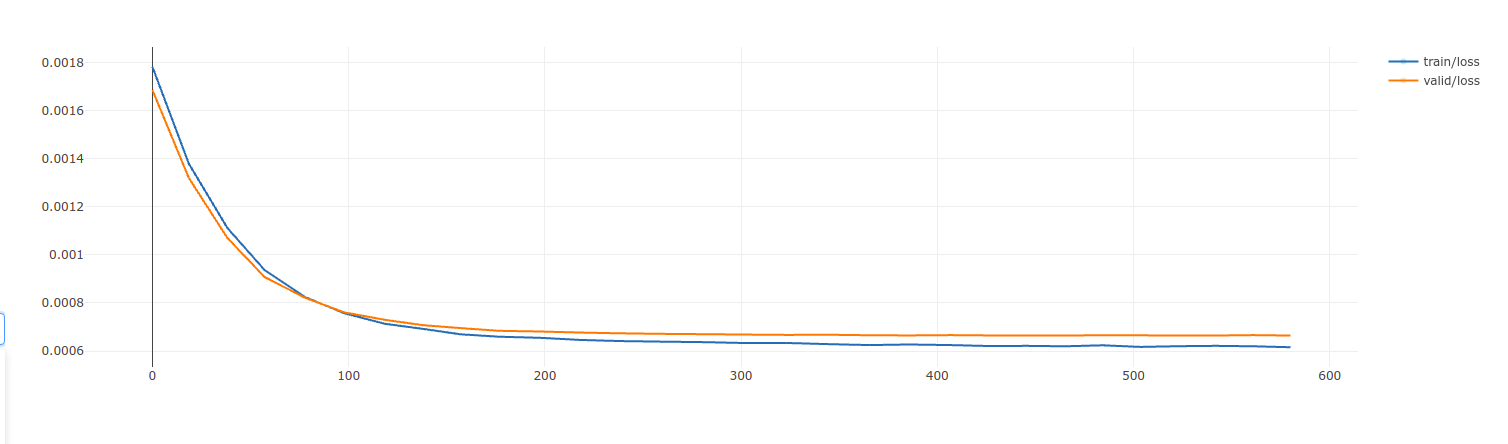

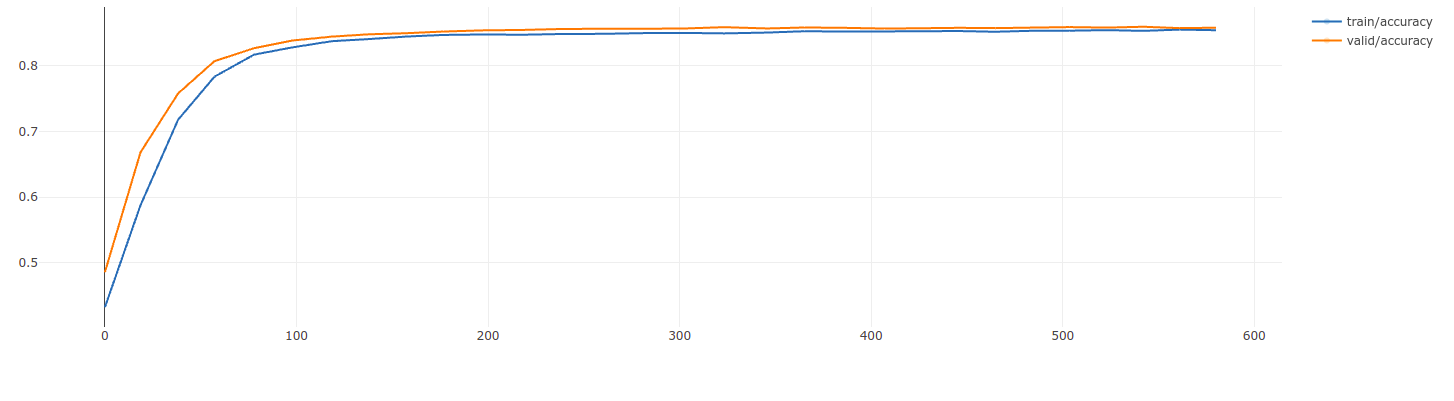